# Introduction
## Contexte de l'étude
Cette analyse s'appuie sur les données de l'article scientifique intitulé "Framing side effects positively improves clinical trial participants’ perceived control and reduces symptom burden: A randomized controlled trial", publié dans PLOS ONE (https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0209851#pone-0209851-g001).
L'étude explore comment le cadrage positif des effets secondaires (en les présentant comme un signe que le médicament est actif) influence la perception des participants et leur fardeau symptomatique, par rapport à un cadrage neutre ou négatif.

### Source des données
Les données utilisées dans ce notebook proviennent du fichier Excel raw_data_framing_side_effects_positively.xlsx, qui contient les données brutes de l'étude. Ce fichier est structuré en deux feuilles :

raw_data : Contient les données des participants, y compris les scores de douleur, les effets secondaires, les scores psychologiques, etc.

metadata : Fournit une description des colonnes et des variables.

## Objectif du notebook
Ce notebook Jupyter a pour objectif de :

1) Décrire et explorer les données (DATA_description) pour comprendre leur structure et leur contenu.

2) Valider les calculs statistiques effectués dans l'article en reproduisant les analyses.

3) Identifier les modèles statistiques utilisés dans l'article et les hypothèses testées.

 4) Effectuer un rééchantillonnage pour vérifier la robustesse des résultats.



## 1. DATA_description


Objectif

Explorer les données pour comprendre leur structure, les variables disponibles et les relations entre elles.

Identifier les variables clés (par exemple, scores de douleur, effets secondaires, scores psychologiques)

#### 1.1.Importation des données : Charger le fichier Excel et explorer les premières lignes.

In [2]:
import pandas as pd

# Spécifiez le chemin complet du fichier Excel
file_path = r"C:\Users\nassi\OneDrive\Desktop\nassim dammak\annee universitaire 2024-2025\INRIA\statistiques-\raw_data_framing_side_effects_positively.xlsx"
df = pd.read_excel(file_path, sheet_name="raw_data")

# Afficher les 5 premières lignes 
df.head()

,record_id,@1N_2P,mean_mod_Av,mean_mod_Après,Delta_Mean_Mod,LOT_Score,score_ASI,Score_stai,Score_Pers,Score_Cat,...,age,conc1,anx1,fatigue1,conc2,anx2,fatigue2,seq_test,mean_intensity_total,mean_intensity_attr
0,102,1,2.828571,1.957143,-0.871429,17,22,20,28,-,...,18,8.0,1.0,6.0,8.0,0,6.0,46.0,1.600000,1.0
1,104,1,3.685714,2.842857,-0.842857,18,20,26,44,-,...,22,6.0,0.0,7.0,7.0,0,5.0,46.0,1.666667,1.0
2,105,1,3.557143,1.700000,-1.857143,18,8,26,37,0,...,21,7.0,2.0,4.0,8.0,5,4.0,47.0,1.000000,1.0
3,106,1,3.842857,3.857143,0.014286,14,20,36,42,1,...,22,8.0,3.0,4.0,0.0,0,0.0,47.0,1.000000,1.0
4,107,1,4.100000,4.657143,0.557143,17,6,20,24,0,...,30,5.0,0.0,2.0,5.0,0,2.0,47.5,0.000000,0.0


#### 1.2.	Nettoyage des données : Vérifier les valeurs manquantes, les formats de données et les éventuelles erreurs.

In [6]:
# Vérifier les valeurs manquantes
missing_values = df.isnull().sum()
print("Valeurs manquantes par colonne :")
print(missing_values)

# Afficher le nombre total de valeurs manquantes
total_missing_values = missing_values.sum()
print("\nNombre total de valeurs manquantes :", total_missing_values)

# Afficher les lignes contenant des valeurs manquantes
rows_with_missing_values = df[df.isnull().any(axis=1)]
print("\nLignes contenant des valeurs manquantes :")
print(rows_with_missing_values)

# Vérifier les formats de données
print("\nFormats de données :")
print(df.dtypes)

# Identifier les éventuelles erreurs (exemple : valeurs négatives dans une colonne qui ne devrait pas en avoir)
# Supposons que la colonne 'age' ne doit pas contenir de valeurs négatives
invalid_age = df[df['age'] < 0]
print("\nValeurs invalides dans la colonne 'age' :")
print(invalid_age)

# Afficher le nombre total de valeurs invalides dans la colonne 'age'
total_invalid_age = invalid_age.shape[0]
print("\nNombre total de valeurs invalides dans la colonne 'age' :", total_invalid_age)

# Corriger les erreurs (exemple : remplacer les valeurs négatives par NaN)
df.loc[df['age'] < 0, 'age'] = pd.NA

Valeurs manquantes par colonne :
record_id               0
@1N_2P                  0
mean_mod_Av             0
mean_mod_Après          0
Delta_Mean_Mod          0
                       ..
anx2                    0
fatigue2                0
seq_test                0
mean_intensity_total    0
mean_intensity_attr     0
Length: 70, dtype: int64

Nombre total de valeurs manquantes : 63

Lignes contenant des valeurs manquantes :
    record_id  @1N_2P  mean_mod_Av  mean_mod_Après  Delta_Mean_Mod  LOT_Score  \
1         104       1     3.685714        2.842857       -0.842857         18   
2         105       1     3.557143        1.700000       -1.857143         18   
3         106       1     3.842857        3.857143        0.014286         14   
4         107       1     4.100000        4.657143        0.557143         17   
5         111       1     7.414286        6.600000       -0.814286         16   
..        ...     ...          ...             ...             ...        ...   
61   

#### 1.3	Statistiques descriptives : Calculer des indicateurs clés (moyennes, écarts-types, etc.) pour chaque groupe (contrôle vs positif).

Sépare les données en deux groupes (groupe_controle et groupe_positif) en utilisant la colonne @1N_2P.
Calcule la moyenne, l'écart-type, la médiane et le nombre d'observations pour chaque groupe.
Crée un DataFrame statistiques_df pour afficher les résultats sous forme de tableau.
Affiche les résultats

In [7]:
import pandas as pd

# Séparer les données en deux groupes : groupe 1 (contrôle) et groupe 2 (positif)
groupe_controle = df[df['@1N_2P'] == 1]
groupe_positif = df[df['@1N_2P'] == 2]

# Calculer les statistiques descriptives pour chaque groupe
statistiques = {
    'Groupe': ['Contrôle', 'Positif'],
    'Moyenne': [groupe_controle['Delta_Mean_Mod'].mean(), groupe_positif['Delta_Mean_Mod'].mean()],
    'Écart-type': [groupe_controle['Delta_Mean_Mod'].std(), groupe_positif['Delta_Mean_Mod'].std()],
    'Médiane': [groupe_controle['Delta_Mean_Mod'].median(), groupe_positif['Delta_Mean_Mod'].median()],
    'Nombre d\'observations': [groupe_controle['Delta_Mean_Mod'].count(), groupe_positif['Delta_Mean_Mod'].count()]
}

# Créer un DataFrame pour afficher les résultats sous forme de tableau
statistiques_df = pd.DataFrame(statistiques)

# Afficher les résultats
print(statistiques_df)

     Groupe   Moyenne  Écart-type   Médiane  Nombre d'observations
0  Contrôle -1.026840    1.173059 -0.828571                     33
1   Positif -1.052381    1.221364 -1.100000                     33


#### 1.4	Visualisations : Créer des graphiques pour explorer les distributions et les relations entre les variables.

c:\Users\nassi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nassi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\nassi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\nassi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a len

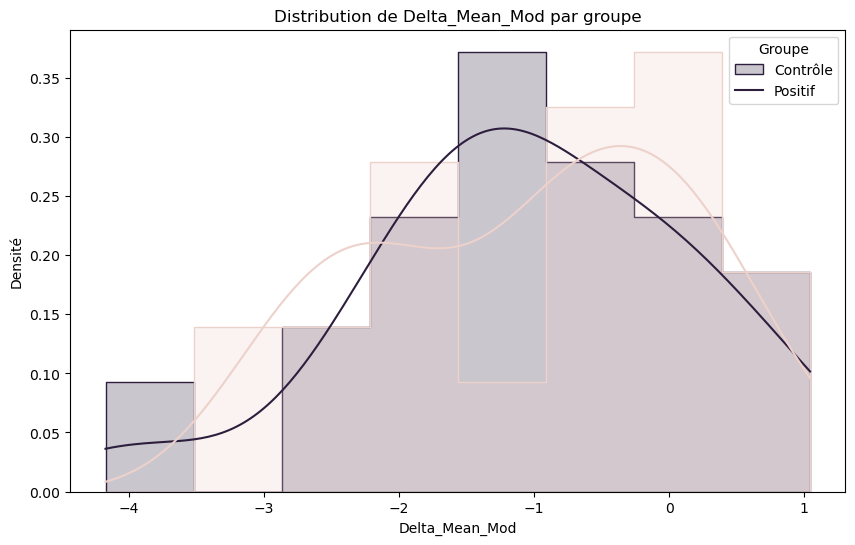

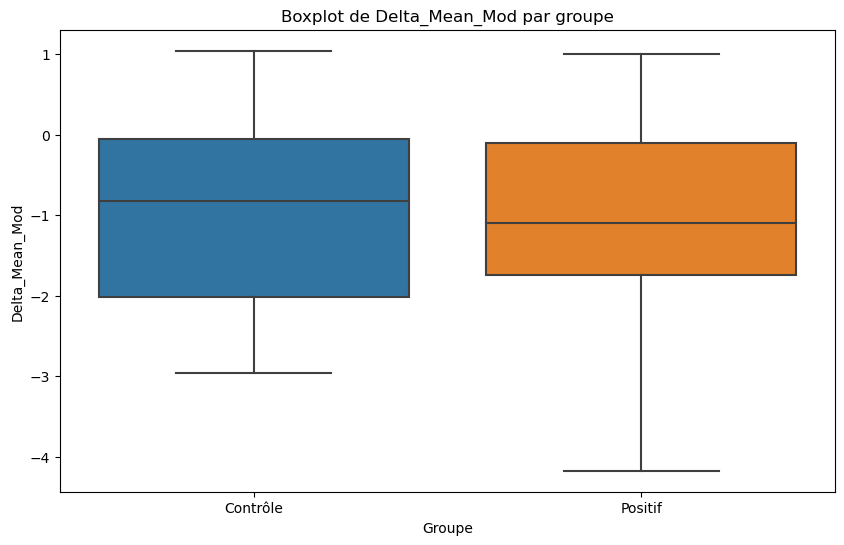

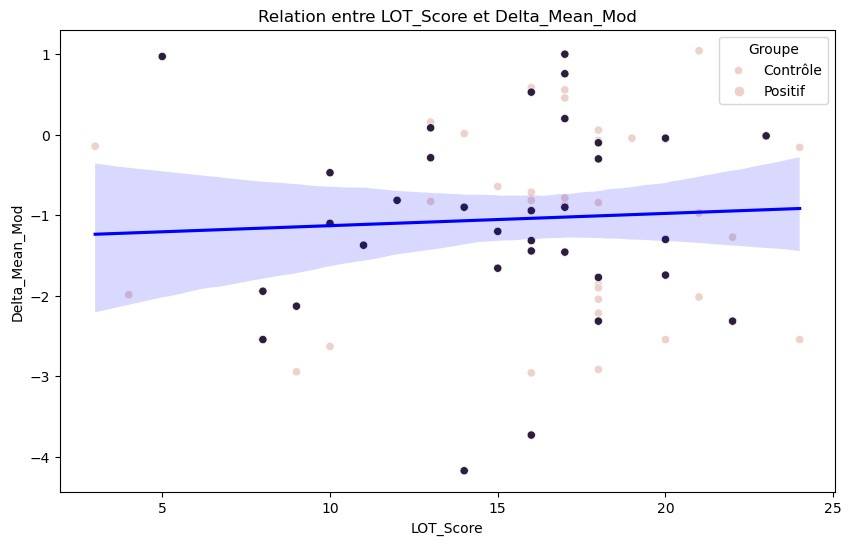

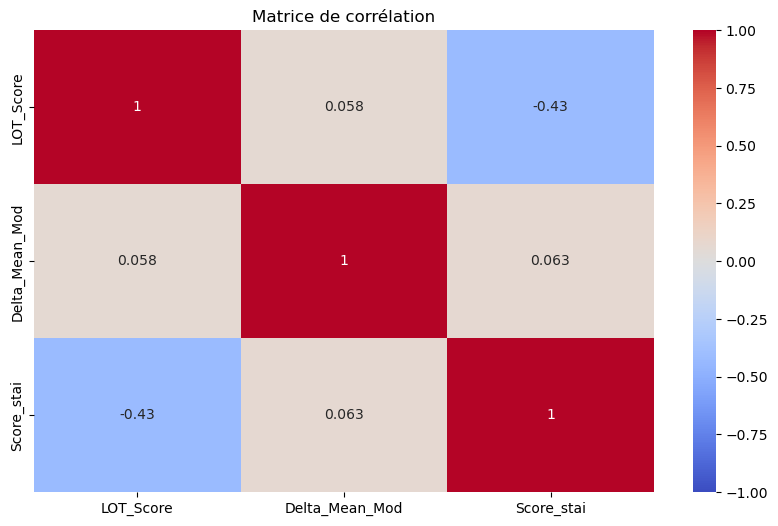

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histogrammes
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Delta_Mean_Mod', hue='@1N_2P', kde=True, element='step', stat='density', common_norm=False)
plt.title('Distribution de Delta_Mean_Mod par groupe')
plt.xlabel('Delta_Mean_Mod')
plt.ylabel('Densité')
plt.legend(title='Groupe', labels=['Contrôle', 'Positif'])
plt.show()

# Boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='@1N_2P', y='Delta_Mean_Mod')
plt.title('Boxplot de Delta_Mean_Mod par groupe')
plt.xlabel('Groupe')
plt.ylabel('Delta_Mean_Mod')
plt.xticks([0, 1], ['Contrôle', 'Positif'])
plt.show()

# Nuages de points avec ligne de régression
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='LOT_Score', y='Delta_Mean_Mod', hue='@1N_2P')
sns.regplot(data=df, x='LOT_Score', y='Delta_Mean_Mod', scatter=False, color='blue')
plt.title('Relation entre LOT_Score et Delta_Mean_Mod')
plt.xlabel('LOT_Score')
plt.ylabel('Delta_Mean_Mod')
plt.legend(title='Groupe', labels=['Contrôle', 'Positif'])
plt.show()

# Matrice de corrélation
plt.figure(figsize=(10, 6))
corr_matrix = df[['LOT_Score', 'Delta_Mean_Mod', 'Score_stai']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matrice de corrélation')
plt.show()